In [1]:
import saftgmie as saft
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
import scipy
from scipy.optimize import fsolve, least_squares, leastsq

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn import preprocessing

First, we have to generate the data we need to fit the phase diagram. With the SAFT model developed, the system can be easily defined, and populated with the desired coarse grained molecules with their respective parameters. Here, we first define two pure systems, of hexane (3 CG beads of $\lambda_r = 19.33$, $\lambda_a = 6.00$, $\sigma = 0.451\ \text{nm}$, $\epsilon/k_b = 377.012\ \text{K}$) and methane (1 CG bead of $\lambda_r = 16.391$, $\lambda_a = 6.00$, $\sigma = 0.375\ \text{nm}$, $\epsilon/k_b = 170.754\ \text{K}$). 

In [2]:
c6bead = saft.GroupType(19.32993437, 6., 0.450874, 377.0118945, shape_factor=1)
c1bead = saft.GroupType(16.39077548, 6., 0.375227, 170.7540156, shape_factor=1)

hexane = saft.Component(16.04).quick_set((c6bead, 2))
methane = saft.Component(86.1754).quick_set((c1bead, 1))

pure_methane = saft.System().quick_set((methane, 1000))
pure_hexane = saft.System().quick_set((hexane, 1000))
mixture = saft.System().quick_set((methane, 500), (hexane, 500))

  2 groups were to be added,   2 groups were added
  1 groups were to be added,   1 groups were added


After setting up the system, generate data by using the following functions: 
* `pressure (, gibbs) = .p_v_isotherm(volume, temperature=None, gibbs=False)` 
* `pressure = .p_rho_isotherm(number_density, temperature=None)` 
* `pv (,vle, gibbs) = .vapour_pressure(temperature=None, initial_guess=(1-e4,1), get_volume=False, get_gibbs=False, print_results=True)`
* `volume (, density) = .single_phase_v(P, T=None, print_results=True, get_density=False)`

When generating data, we have to ensure that the data points are well spread out. This has two complications:
1. Data spaces between volume and temperature spacing have to be uniform. This means that if I have say 1000 volume points per temperature for 100 temperature, the machine learning would favour fitting volume shape over accuracy in temperature. As a result, the number of data points for each isotherm have to be carefully planned out.
2. Also, the high gradient in a P-v isotherm in liquid phase is easily to extreme pressure points which results in unnecessarily high spread in data. It is hence necessary to generate points with respect to spread in pressure here instead of molar volume / density. This liquid density where the pressure gradient becomes steep also depends on the temperature, hence we have to first calculate the vapour pressure and the liquid density before generating the data points.

In [3]:
# For hexane

print("="*5,"Generating hexane (19.33/6.0) data (P,v,T)","="*5)

temp_range = np.linspace(300,477,200)
v_liquid = np.zeros(np.size(temp_range))
v_vapour = np.zeros(np.size(temp_range))
g_eq = np.zeros(np.size(temp_range))
p_vap = np.zeros(np.size(temp_range))
# 2 phase data
tsize = np.size(temp_range)
start_time = time.time()

for i in range(tsize):
    t = temp_range[i]
    pv, vle, geq = pure_hexane.vapour_pressure(t, get_volume=True, get_gibbs=True, print_results=False)
    p_vap[i] = pv
    v_liquid[i] = min(vle)
    v_vapour[i] = max(vle)
    g_eq[i] = geq
    elapsed_time = time.time() - start_time
    print(f'VLE data generation at {int((i+1)*100/tsize):3d}% complete, time elapsed: {elapsed_time:5.2f} s', end='\r')
df = pd.DataFrame(np.column_stack([temp_range, p_vap, v_liquid, v_vapour, g_eq]))
outputfile = 'pure-hexane-vle.csv'
df.to_csv(outputfile, index=False)

print(f'Data generation complete. Output file: {outputfile}', ' '*5)

===== Generating hexane (19.33/6.0) data (P,v,T) =====
Data generation complete. Output file: pure-hexane-vle.csv      


Plotting graph to show the VLE curve. This is somewhat what we are aiming to predict. For hexane, the critical temperature and pressure is 507.6 K and 3.02 MPa, and nearing the critical point, the algorithm to calculate VLE points become very difficult to converge, which results in mistaken points that doesn't fit the VLE envelope correctly. As a result, the envelope displayed will be missing the critical region. Hopefully, machine learning methods will help us kind of predict this envelop.

Text(0.5,1,'VLE envelope')

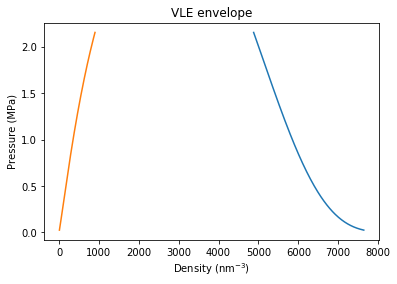

In [4]:
fig, ax = plt.subplots()
ax.plot(1/v_liquid, p_vap * 1e-6, '-', label='liquid boundary')
ax.plot(1/v_vapour, p_vap * 1e-6, '-', label='vapour boundary')

ax.set_ylabel("Pressure (MPa)")
ax.set_xlabel("Density (nm$^{-3}$)")
ax.set_title("VLE envelope")

Now, with the relevant data for liquid and vapour density / molar volume, we can generate data within the ranges using the SAFT-$\gamma$ Mie EoS for each respective phase (vapour, liquid, v-l). For the liquid region, it would be more reasonable to generate data by intervals in pressure due to the extremely steep gradient for pressure at very small change in volume. For the vapour-liquid and vapour region, we should generate in intervals of volume, density or log of volume, depending which would give use better results. 

In [ ]:
fig, ax = plt.subplots()
T = 480
for t in [477]:
    testpv, testvle = pure_hexane.vapour_pressure(t, get_volume=True, print_results=False)
    print(f'{t:d}: {testvle[0]:7.4e}, {testvle[1]:7.4e}')

# v = np.logspace(-4, 0, 200)
# p,g = pure_hexane.p_v_isotherm(v, temperature=T, gibbs=True)
ax.semilogx(v,p,'b-')
ax.semilogx([testvle[0], testvle[0]], [0,30e5], 'k-')
ax.semilogx([testvle[1], testvle[1]], [0,30e5], 'k-')
ax.set_ylim((0,30e5))

ax2 = ax.twinx()
ax2.semilogx(v,g*6.023e23,'r-')
ax2.set_ylim((8e3, 1e4))
ax.set_ylabel("Pressure (MPa)")
ax.set_xlabel("Volume (nm$^{3}$)")
ax.set_title("PV Isotherm")

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0,1, 1000)
y1 = 1/(1-x)
y2 = 1/(1-x**2)
ax.plot(x,y1,'-')
ax.plot(x,y2,'-')
# x0size = 50
# x1size = 50
# x0 = np.linspace(1e-5,1,x0size)
# x1 = np.repeat(np.linspace(1e-5,1,x1size), x0size)
# x0 = np.tile(x0, x1size)
# value = 1/(1-abs(x0/x1))

# ax.plot_trisurf(x0,x1,value,linewidth=0.2, antialiased=True,cmap=plt.cm.CMRmap)